
**CICIDS2017 EDA**

The CICIDS2017 dataset was download from https://www.unb.ca/cic/datasets/ids-2017.html

In [1]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [2]:
# Read all csv files from MachineLearningCVE directory

directory_path = "/content/drive/My Drive/MachineLearningCVE/"

os.chdir(directory_path)
file_pattern = os.path.join(directory_path, '*.csv')
csv_files = glob.glob(file_pattern)

dfs = []
for file in csv_files:
    filename = os.path.basename(file)
    df = pd.read_csv(file)
    df['filename'] = filename
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.columns = combined_df.columns.str.strip() # Remove leading spaces from column names
combined_df['Day'] = combined_df['filename'].apply(lambda x: x.split('-')[0]) # add a day column

# Add a Time varaible
def map_time_period(filename):
    if 'Morning' in filename:
        return 'Morning'
    elif 'Afternoon' in filename:
        return 'Afternoon'
    else:
        return 'None'

combined_df['Time'] = combined_df['filename'].apply(map_time_period)

## show the dataframe
combined_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,filename,Day,Time
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv,Friday,Afternoon
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv,Friday,Afternoon
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv,Friday,Afternoon
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv,Friday,Afternoon
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv,Friday,Afternoon


In [34]:
print ('The data has {0} rows and {1} columns'.format(combined_df.shape[0],combined_df.shape[1]))

The data has 2830743 rows and 82 columns


In [3]:
# Missing value counts in each of these columns
miss = combined_df.isnull().sum()/len(combined_df)
miss = miss[miss > 0]
print(miss.sort_values(inplace=True))
print(miss)

# We will delete the rows of missing values:
combined_df.dropna(inplace=True)

None
Flow Bytes/s    0.00048
dtype: float64


There is just one column with missing values of 0.0048% which are 1358 rows. If we will use this variable in the following analysis we will remove these rows.

In [ ]:
# The number of duplicate rows
print(len(combined_df[combined_df.duplicated()]))

255480


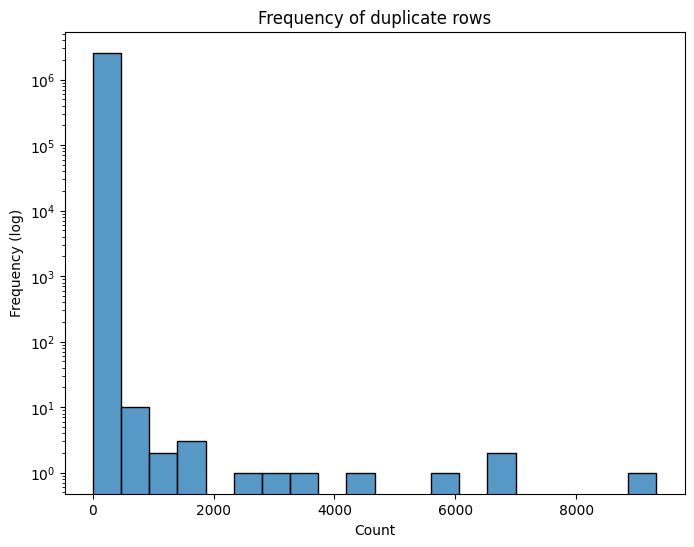

In [3]:
# The frequency of duplicate rows
row_counts = combined_df.groupby(combined_df.columns.tolist()).size().reset_index().rename(columns={0:'count'})

plt.figure(figsize=(8, 6))  # Set figure size
sns.histplot(data=row_counts, x='count', bins=20)  # Adjust bins as needed
plt.xlabel('Count')
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Frequency of duplicate rows')
plt.show()

We can see that there are some rows which have many duplicates. There is one row which appear 9329 times

In [4]:
# We will remove all duplicate rows:

combined_df_unique = combined_df.drop_duplicates()
print(len(combined_df_unique))
print(len(combined_df_unique)/len(combined_df)*100)

2573905
90.97047591614432


We remained with 2573905 rows which are 90% from the data rows.

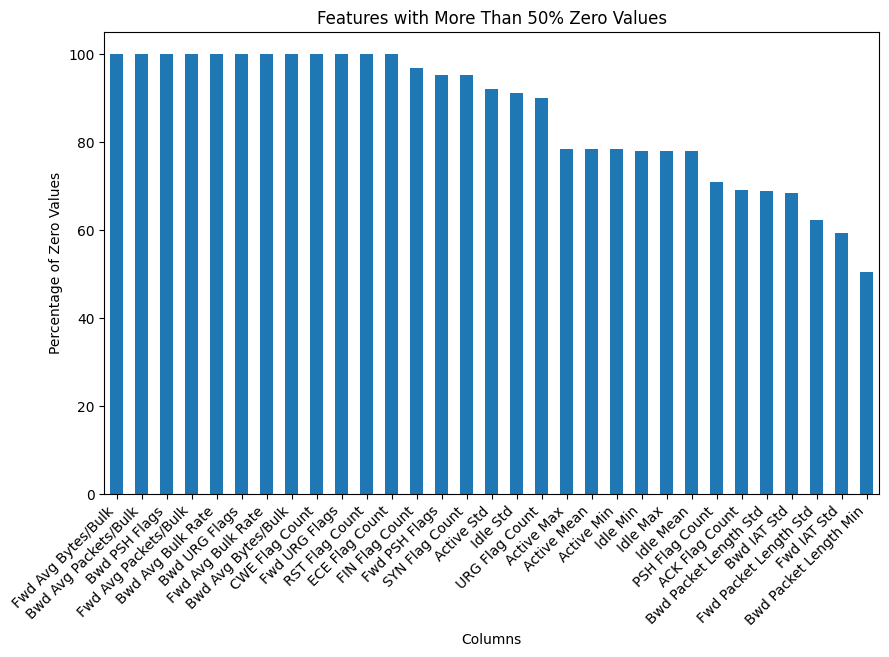

In [5]:
# Check which columns have many 0 values:
zero_percentages = (combined_df_unique == 0).mean() * 100
zero_percentages_sorted = zero_percentages.sort_values(ascending=False)
zero_percentages_sorted[zero_percentages_sorted<90]

# Show features with more than 50% zero values
zero_percentages_above_50 = zero_percentages_sorted[zero_percentages_sorted > 50]
plt.figure(figsize=(10, 6))  # Set figure size
zero_percentages_above_50.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Percentage of Zero Values')
plt.title('Features with More Than 50% Zero Values')
plt.xticks(rotation=45, ha='right')
plt.show()

In [6]:
# Remove columns which all values are 0 (100%)
remove_columns = zero_percentages_sorted[zero_percentages_sorted==100].index.tolist()
combined_df_unique_filter = combined_df_unique.drop(columns=remove_columns, inplace=False)

combined_df_unique_filter.shape

(2573905, 74)

In [8]:
# Separate variables into numeric and categoric data frames
numeric_data = combined_df_unique_filter.select_dtypes(include=[np.number])
cat_data = combined_df_unique_filter.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in the data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 70 numeric and 4 categorical columns in the data


Now, we are interested to learn about the correlation behavior of numeric variables.
Out of 70 variables, I presume some of them must be correlated. If found, we can later remove these correlated variables as they won't provide any useful information to the model.

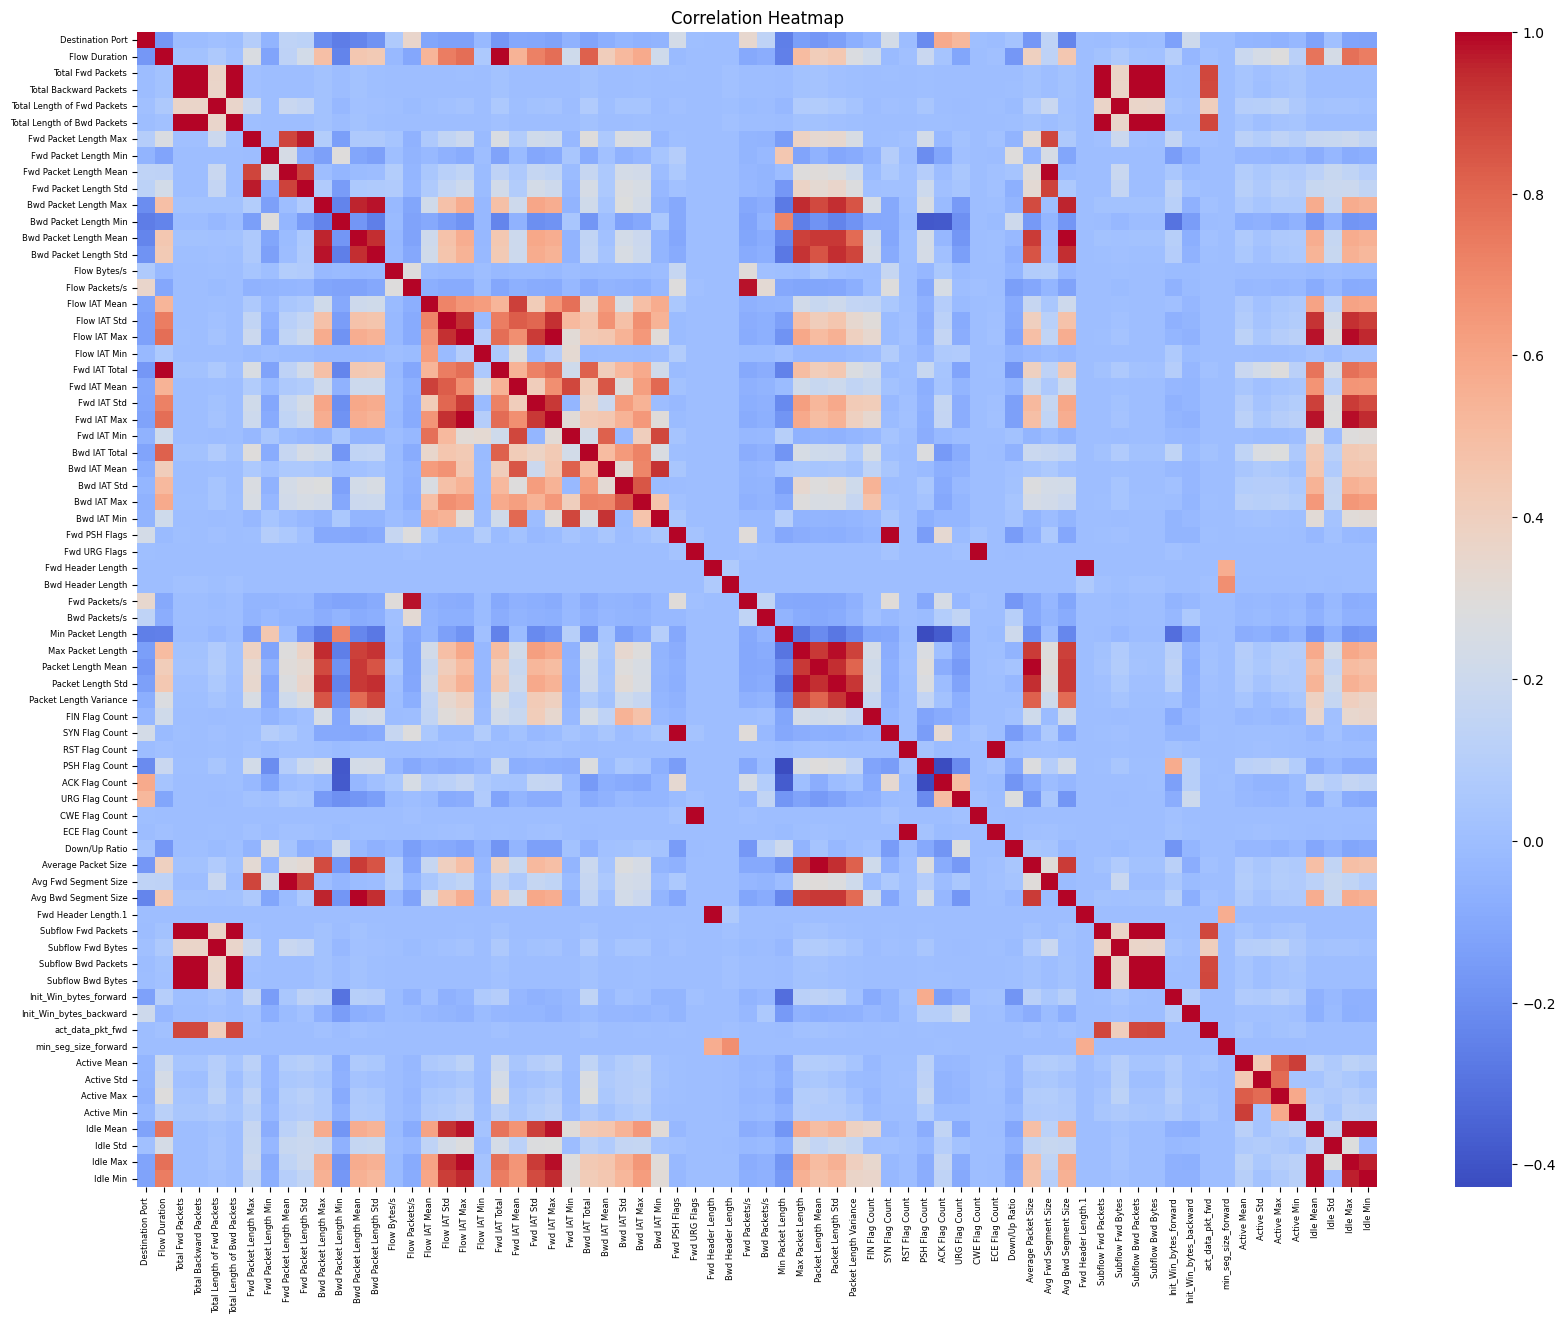

In [9]:
# Correlation plot
corr = numeric_data.corr()

plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Heatmap')
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=6)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=6)
plt.show()

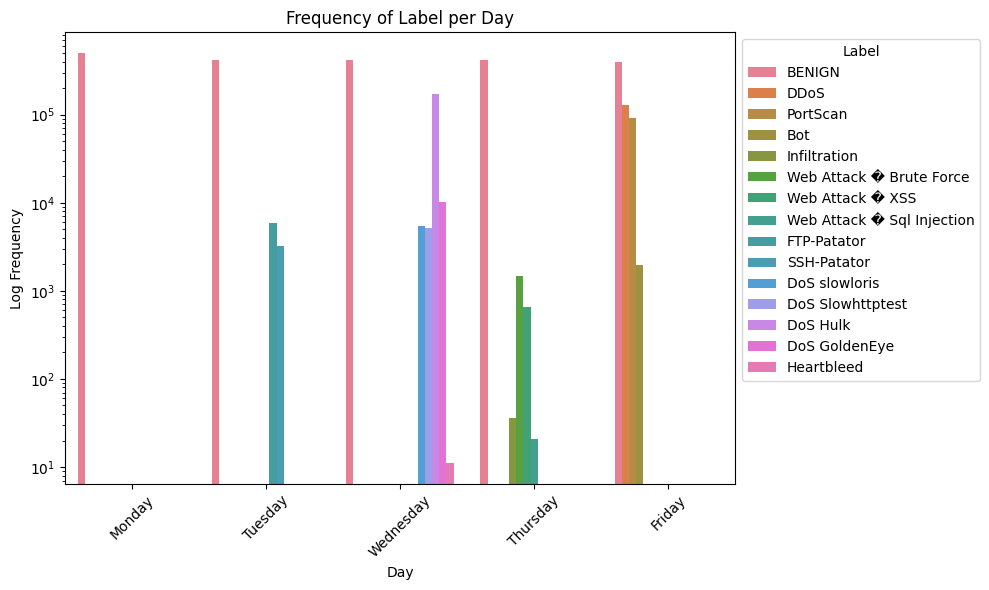

In [ ]:
# The categorical variables are the label and the day

custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Plot the frequncey of label per day
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df_unique_filter, x='Day', hue='Label', order=custom_order)
plt.xlabel('Day')
plt.ylabel('Log Frequency')
plt.yscale('log')
plt.title('Frequency of Label per Day')
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<Figure size 1000x600 with 0 Axes>

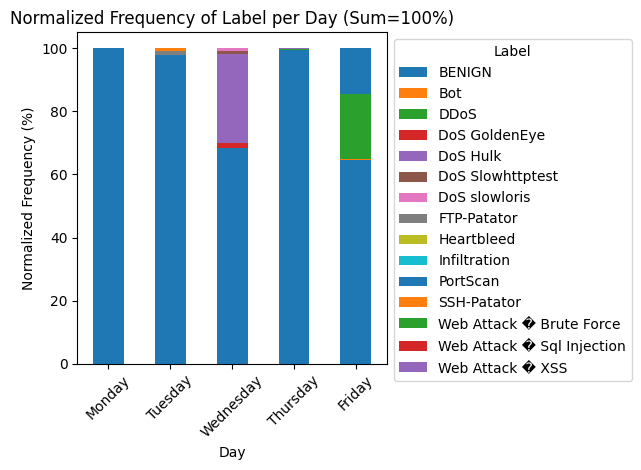

In [ ]:
# Plot the frequncey of label per day using stacked barplot to see the distribution

custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.figure(figsize=(10, 6))  # Set figure size
# Group the data by 'Day' and 'Label', then count the occurrences
grouped = combined_df_unique_filter.groupby(['Day', 'Label']).size().unstack(fill_value=0)
# Normalize counts to sum up to 100 for each day
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100
# Reorder the index of the DataFrame according to custom order
grouped_percent = grouped_percent.reindex(custom_order)
# Plot stacked bar plot
grouped_percent.plot(kind='bar', stacked=True)
plt.xlabel('Day')
plt.ylabel('Normalized Frequency (%)')
plt.title('Normalized Frequency of Label per Day (Sum=100%)')
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<Figure size 1000x600 with 0 Axes>

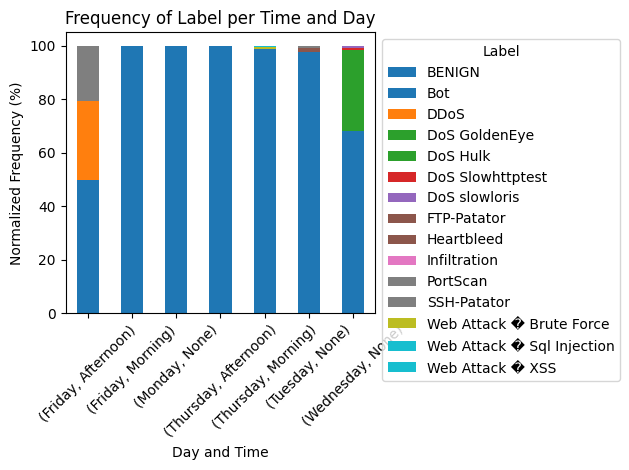

In [ ]:
# Plot by day and time

grouped = combined_df_unique_filter.groupby(['Day', 'Time', 'Label']).size().unstack(fill_value=0)
# Normalize counts to percentages
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100
# Plot stacked bar plot
plt.figure(figsize=(10, 6))
grouped_percent.plot(kind='bar', stacked=True, cmap='tab10')
plt.xlabel('Day and Time')
plt.ylabel('Normalized Frequency (%)')
plt.title('Frequency of Label per Time and Day')
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It's evident that the majority of attacks occur on Friday afternoons and Wednesdays.

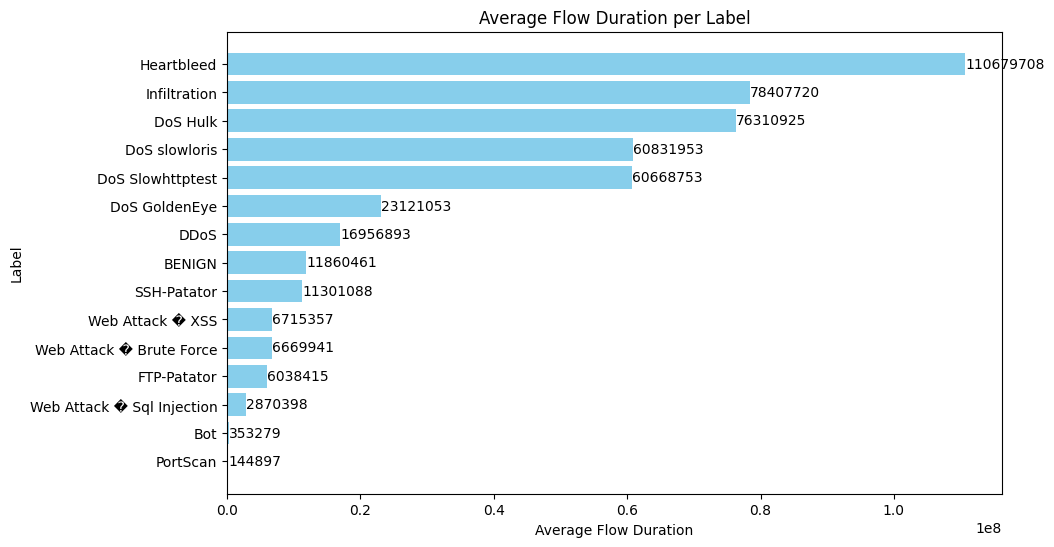

In [29]:
average_flow_duration = combined_df_unique_filter.groupby('Label')['Flow Duration'].mean()
average_flow_duration.sort_values(ascending=True, inplace=True)
average_flow_duration = pd.DataFrame(average_flow_duration)
average_flow_duration = average_flow_duration.reset_index(drop=False)  # Reset index and drop the old index column
average_flow_duration = average_flow_duration.rename(columns={'Label': 'Label', 'Flow Duration': 'Average Flow Duration'})
average_flow_duration

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(average_flow_duration['Label'], average_flow_duration['Average Flow Duration'], color='skyblue')
# Add text labels on each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.0f}', ha='left', va='center')

plt.xlabel('Average Flow Duration')
plt.ylabel('Label')
plt.title('Average Flow Duration per Label')

plt.show()

In [7]:
# Apply ANOVA to examine the distribution of Flow Duration per Label.
# ANOVA can help determine whether there are statistically significant differences in the average flow duration among different attack types.

from scipy.stats import f_oneway

# Extract flow duration data for each attack type
attack_types = combined_df_unique_filter['Label'].unique()
flow_duration_per_attack = [combined_df_unique_filter[combined_df_unique_filter['Label'] == attack]['Flow Duration'] for attack in attack_types]

# Perform one-way ANOVA
statistic, p_value = f_oneway(*flow_duration_per_attack)

print(f"ANOVA statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There are statistically significant differences in the average flow duration among different attack types.")
else:
    print("There are no statistically significant differences in the average flow duration among different attack types.")

ANOVA statistic: 53801.07035097575
P-value: 0.0
There are statistically significant differences in the average flow duration among different attack types.


We observe a substantial discrepancy in the average flow duration across different types of attacks. Given this variance, I anticipate that the average flow duration will emerge as a significant variable when classifying the various types of attacks.

Read the second data from TrafficLabelling_ directory

In [ ]:
# Read all csv files from TrafficLabelling_ directory #####
directory_path2 = "/content/drive/My Drive/TrafficLabelling_"
os.chdir(directory_path2)
file_pattern = os.path.join(directory_path2, '*.csv')
csv_files = glob.glob(file_pattern)

dfs2 = []
for file in csv_files:
  filename = os.path.basename(file)
  df = pd.read_csv(file, encoding='latin1', low_memory=False)
  df['filename'] = filename
  dfs2.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df2 = pd.concat(dfs2, ignore_index=True)
combined_df2.columns = combined_df2.columns.str.strip() # Remove leading spaces from column names
combined_df2['Day'] = combined_df2['filename'].apply(lambda x: x.split('-')[0])

def map_time_period(filename):
    if 'Morning' in filename:
        return 'Morning'
    elif 'Afternoon' in filename:
        return 'Afternoon'
    else:
        return 'None'

combined_df2['Time'] = combined_df2['filename'].apply(map_time_period)

## Show the dataframe
combined_df2.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,filename,Day,Time
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,Monday-WorkingHours.pcap_ISCX.csv,Monday,None
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,Monday-WorkingHours.pcap_ISCX.csv,Monday,None
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,Monday-WorkingHours.pcap_ISCX.csv,Monday,None
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,Monday-WorkingHours.pcap_ISCX.csv,Monday,None
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80.0,192.168.10.14,49486.0,6.0,03/07/2017 08:56:22,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,Monday-WorkingHours.pcap_ISCX.csv,Monday,None


In [ ]:
# Remove all duplicates:
combined_df2_unique = combined_df2.drop_duplicates()
len(combined_df2_unique)
len(combined_df2_unique)/len(combined_df2)*100

del combined_df2

In [ ]:
# Check which columns have many 0 values:
zero_percentages = (combined_df2_unique == 0).mean() * 100
zero_percentages_sorted = zero_percentages.sort_values(ascending=False)

# Remove columns which all values are 0 (100%)
remove_columns = zero_percentages_sorted[zero_percentages_sorted==100].index.tolist()
combined_df2_unique_filter = combined_df2_unique.drop(columns=remove_columns, inplace=False)

del combined_df2_unique

combined_df2_unique_filter.shape


In [ ]:
# Check which columns appear in TrafficLabelling_ files and did not appear in MachineLearningCVE files
columns_df1 = set(combined_df_unique_filter.columns)
columns_df2 = set(combined_df2_unique_filter.columns)

# Find columns that appear in df2 but not in df1
columns_only_in_df2 = columns_df2 - columns_df1

print("Columns appearing in TrafficLabelling_ files but not in MachineLearningCVE files:")
print(columns_only_in_df2)

Columns appearing in TrafficLabelling_ files but not in MachineLearningCVE files:
{'Source Port', 'Protocol', 'Flow ID', 'Source IP', 'Timestamp', 'Destination IP'}


In [ ]:
# Merge TrafficLabelling_ files with MachineLearningCVE files

shared_columns = combined_df_unique_filter.columns.intersection(combined_df2_unique_filter.columns)

# Check all share columns have the same dtype

for column in combined_df2_unique_filter.columns:
    if column in combined_df_unique_filter.columns:
        dtype_column = combined_df2_unique_filter[column].dtype
        combined_df_unique_filter[column] = combined_df_unique_filter[column].astype(dtype_column)

merged_df2 = pd.merge(combined_df2_unique_filter, combined_df_unique_filter, on=list(shared_columns), how='left')
print(merged_df2.shape)

I halted the EDA at this point, but there are numerous avenues for further investigation. By merging the TrafficLabelling_ files, we can delve into the various source ports associated with each attack label. This exploration could provide valuable insights into the behaviors of attackers and enhance our understanding of the dataset.